In [7]:
from Functions2 import *
from DataDefined2 import *

df = pd.read_csv('Driving Data(KIA SOUL)_(150728-160714)_(10 Drivers_A-J).csv')

# Out-of-distribution class
CLASS_OOD = 1

In [8]:
# Dropping columns
columns_to_drop = one_val_col + irrelevant_col
df = df.drop(columns_to_drop, axis=1)

# Adding columns
df = addRideNumbers(df)

In [9]:
for driver_class in sorted(df['Class'].unique()):
    driver_data = df[df['Class'] == driver_class]
    ride_counts = driver_data['Ride number'].unique()
    print(f"Ride number for Class {driver_class}: {ride_counts}")

Ride number for Class A: [1 2 3 4]
Ride number for Class B: [1 2 3 4 5 6]
Ride number for Class C: [1 2 3 4]
Ride number for Class D: [1 2 3 4 5 6]
Ride number for Class E: [1 2 3 4]
Ride number for Class F: [1 2 3 4]
Ride number for Class G: [1 2 3 4]
Ride number for Class H: [1 2 3 4]
Ride number for Class I: [1 2 3 4]
Ride number for Class J: [1 2 3 4]


In [10]:
# Encode the class first, as this cannot be encoded after the train-test-split, due to being out-of-distribution
encoder = LabelEncoder()
df['Class'] = encoder.fit_transform(df['Class'])

train_df, test_df = split_train_test_ood(df, CLASS_OOD, frac=0.15)

# Normalize
columns_to_scale = numerical_col + two_val_col
train_df, test_df = normalize_data(train_df, test_df, columns_to_scale)
# Encode
train_df, test_df = label_encode(train_df, test_df, categorical_col)

print("Classes in train:", len(train_df['Class'].unique()))
print("Classes in test:", len(test_df['Class'].unique()))

Classes in train: 9
Classes in test: 10


In [11]:
# Convert to input for the model
X_train = torch.tensor(train_df[numerical_col + ['Indication_of_brake_switch_ON/OFF']].values, dtype=torch.float32)
X_test = torch.tensor(test_df[numerical_col + ['Indication_of_brake_switch_ON/OFF']].values, dtype=torch.float32)

y_train = torch.tensor(train_df['Class'].values, dtype=torch.long)
y_test = torch.tensor(test_df['Class'].values, dtype=torch.long)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# To evaluate, the OOD prediction should be compared
# Therefore, change class number that is OOD in the testset to -1
y_test_ood = torch.where(y_test == CLASS_OOD, -1, y_test)

torch.Size([69288, 35])
torch.Size([25092, 35])
torch.Size([69288])
torch.Size([25092])


In [14]:
input_dim = X_train.shape[1]   
model = TabularNN(input_dim)
criterion = nn.CrossEntropyLoss()  # For multi-class classifications
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 500

In [9]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    predictions = model(X_train)  # Logits output
    loss = criterion(predictions, y_train)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Evaluate on test data
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)  # Logits
    # Convert logits to probabilities (using softmax) and get predicted class
    predicted_probs = torch.softmax(test_predictions, dim=1)
    max_probs, predicted_classes = torch.max(predicted_probs, dim=1)
    threshold = 0.65  
    predicted_classes[max_probs < threshold] = -1  

# Normally, one would also calculate the test loss; however, now we have prediction -1, 
# so not sure how to handle that in the loss calculation 
print("Predicted Classes (with OOD detection):", predicted_classes)


Epoch 0, Loss: 2.3304
Epoch 10, Loss: 2.2725
Epoch 20, Loss: 2.2200
Epoch 30, Loss: 2.1532
Epoch 40, Loss: 2.0684
Epoch 50, Loss: 1.9628
Epoch 60, Loss: 1.8470
Epoch 70, Loss: 1.7276
Epoch 80, Loss: 1.6181
Epoch 90, Loss: 1.5250
Epoch 100, Loss: 1.4471
Epoch 110, Loss: 1.3824
Epoch 120, Loss: 1.3278
Epoch 130, Loss: 1.2797
Epoch 140, Loss: 1.2362
Epoch 150, Loss: 1.1958
Epoch 160, Loss: 1.1572
Epoch 170, Loss: 1.1192
Epoch 180, Loss: 1.0832
Epoch 190, Loss: 1.0491
Epoch 200, Loss: 1.0165
Epoch 210, Loss: 0.9859
Epoch 220, Loss: 0.9564
Epoch 230, Loss: 0.9283
Epoch 240, Loss: 0.9017
Epoch 250, Loss: 0.8762
Epoch 260, Loss: 0.8521
Epoch 270, Loss: 0.8290
Epoch 280, Loss: 0.8068
Epoch 290, Loss: 0.7854
Epoch 300, Loss: 0.7646
Epoch 310, Loss: 0.7443
Epoch 320, Loss: 0.7247
Epoch 330, Loss: 0.7053
Epoch 340, Loss: 0.6857
Epoch 350, Loss: 0.6671
Epoch 360, Loss: 0.6498
Epoch 370, Loss: 0.6333
Epoch 380, Loss: 0.6175
Epoch 390, Loss: 0.6024
Epoch 400, Loss: 0.5882
Epoch 410, Loss: 0.5749
Epo

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_ood, predicted_classes)
print(cm)

[[5025   44  158 3387  598  196   78 1263  696 1419]
 [  48 1029    1    0    0    0    7    0    0    1]
 [ 309    1  753   31    0   27    3    1    0    0]
 [ 518    0   20 1371    3   35   17   18    0    5]
 [  25    0    0    0 1239    0    0    0    0    1]
 [ 465    1   11   19    0 1128   13    9    2    4]
 [ 371    6    0   39    0   13  668    8   16    3]
 [ 687    1    2    6    1   17    1  712   16   39]
 [ 697    0    1    0    0    4    5   56  354   54]
 [ 771    2    0    2    2    9    0   38   25  487]]


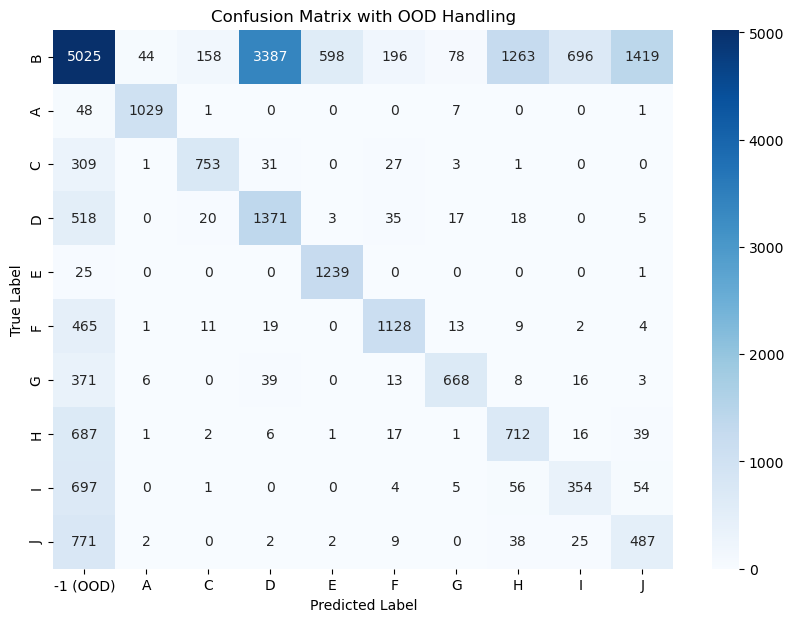

In [15]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_ood, predicted_classes)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels= ['-1 (OOD)',  'A',  'C',  'D',  'E',  'F',  'G',  'H',  'I',  'J'], 
            yticklabels= ['B',  'A',  'C',  'D',  'E',  'F',  'G',  'H',  'I',  'J'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix with OOD Handling')
plt.show()

In [16]:
print(classification_report(y_test_ood, predicted_classes))

              precision    recall  f1-score   support

          -1       0.56      0.39      0.46     12864
           0       0.95      0.95      0.95      1086
           2       0.80      0.67      0.73      1125
           3       0.28      0.69      0.40      1987
           4       0.67      0.98      0.80      1265
           5       0.79      0.68      0.73      1652
           6       0.84      0.59      0.70      1124
           7       0.34      0.48      0.40      1482
           8       0.32      0.30      0.31      1171
           9       0.24      0.36      0.29      1336

    accuracy                           0.51     25092
   macro avg       0.58      0.61      0.58     25092
weighted avg       0.56      0.51      0.52     25092

